<a href="https://colab.research.google.com/github/peoplecallitinsanity/CVC-hm/blob/main/HM5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip archive.zip -d content

Streaming output truncated to the last 5000 lines.
  inflating: content/data/train/benign/420.jpg  
  inflating: content/data/train/benign/421.jpg  
  inflating: content/data/train/benign/422.jpg  
  inflating: content/data/train/benign/423.jpg  
  inflating: content/data/train/benign/424.jpg  
  inflating: content/data/train/benign/425.jpg  
  inflating: content/data/train/benign/426.jpg  
  inflating: content/data/train/benign/429.jpg  
  inflating: content/data/train/benign/43.jpg  
  inflating: content/data/train/benign/430.jpg  
  inflating: content/data/train/benign/431.jpg  
  inflating: content/data/train/benign/432.jpg  
  inflating: content/data/train/benign/434.jpg  
  inflating: content/data/train/benign/435.jpg  
  inflating: content/data/train/benign/438.jpg  
  inflating: content/data/train/benign/439.jpg  
  inflating: content/data/train/benign/440.jpg  
  inflating: content/data/train/benign/441.jpg  
  inflating: content/data/train/benign/442.jpg  
  inflating: conten

In [3]:
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch import optim 
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms,models
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')  

In [4]:
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [5]:
train_data = ImageFolder('/content/content/test', transform = transformations)
test_data = ImageFolder('/content/content/train', transform = transformations)

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # (224,224)
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2)
        
        # (112,112)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        
        self.pool2 = nn.MaxPool2d(2)
        
        # (56,56)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        
        self.pool3 = nn.MaxPool2d(2)
        # (28,28)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128*28*28,256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,1)
    
    def forward(self, x):
        out = self.pool1(F.relu(self.conv1(x)))
        out = self.pool2(F.relu(self.conv2(out)))
        out = self.pool3(F.relu(self.conv3(out)))
        
        out = self.flatten(out)
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        
        return out

In [7]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, print_plot=True):

    #Initializing two lists to save accuracy to plot them later
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    #Going thru every epoch
    for epoch in range(n_epochs):

        #Going thru example, thru every batch, in our case, thru all data at once
        for example, labels in train_loader:     

            #Translating calculations to gpu if is available
            example = example.to(DEVICE)
            labels = labels.to(DEVICE)

            # ensuring equal number of dimensions for labels and examples
            labels  = labels.unsqueeze(1)

            # running our data thru our data - forward
            output = model(example.float())
            # Getting loss of our network right now
            loss = loss_fn(output, labels.float())

            # Zeroing the gradient to not stack it from other iterations
            optimizer.zero_grad()
            #Runing backward part of the neural network, getting gradiets
            loss.backward()
            #Updating our paramters
            optimizer.step()
            
            
        with torch.no_grad():
            
            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total
                
        print(f'Epoch {epoch+1})', 
              f'Train Accuracy: {train_accuracy[epoch]}',
              f'Test Accuracy: {test_accuracy[epoch]}')

    #If set to True, print graph of train and validation loss
    if print_plot:

        #Setting x-ticks
        epochs = range(n_epochs)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [8]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle =True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle =True)

Epoch 1) Train Accuracy: 0.7621212005615234 Test Accuracy: 0.7610921263694763
Epoch 2) Train Accuracy: 0.7757575511932373 Test Accuracy: 0.7815699577331543
Epoch 3) Train Accuracy: 0.8151515126228333 Test Accuracy: 0.7717102766036987
Epoch 4) Train Accuracy: 0.8060605525970459 Test Accuracy: 0.7937049865722656
Epoch 5) Train Accuracy: 0.8590908646583557 Test Accuracy: 0.8100113868713379
Epoch 6) Train Accuracy: 0.8742424249649048 Test Accuracy: 0.8236632347106934
Epoch 7) Train Accuracy: 0.863636314868927 Test Accuracy: 0.8035646677017212
Epoch 8) Train Accuracy: 0.8939393758773804 Test Accuracy: 0.8081153035163879
Epoch 9) Train Accuracy: 0.9409090876579285 Test Accuracy: 0.8160789012908936
Epoch 10) Train Accuracy: 0.9151514768600464 Test Accuracy: 0.809252917766571


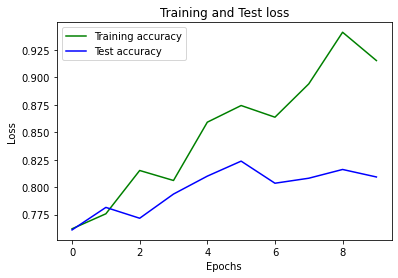

In [9]:
learning_rate = 1e-3 # 0.001

model = Net().to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr = learning_rate)
loss_fn = nn.BCELoss()

training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot = True,
    train_loader = train_loader,
    test_loader = test_loader
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1) Train Accuracy: 0.8196969628334045 Test Accuracy: 0.8103905916213989
Epoch 2) Train Accuracy: 0.8348484635353088 Test Accuracy: 0.8168373107910156
Epoch 3) Train Accuracy: 0.842424213886261 Test Accuracy: 0.8043230772018433
Epoch 4) Train Accuracy: 0.8590908646583557 Test Accuracy: 0.8191125988960266
Epoch 5) Train Accuracy: 0.9015151262283325 Test Accuracy: 0.8255593180656433
Epoch 6) Train Accuracy: 0.8484848141670227 Test Accuracy: 0.8134243488311768
Epoch 7) Train Accuracy: 0.8939393758773804 Test Accuracy: 0.8069776296615601
Epoch 8) Train Accuracy: 0.8939393758773804 Test Accuracy: 0.8028061985969543
Epoch 9) Train Accuracy: 0.924242377281189 Test Accuracy: 0.831626832485199
Epoch 10) Train Accuracy: 0.8999999761581421 Test Accuracy: 0.8081153035163879


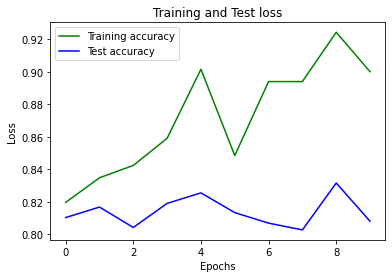

In [10]:
from collections import OrderedDict

model = models.resnet50(pretrained = True)

for param in model.parameters():
    param.required_grad = False
    
nr_feat = model.fc.in_features #2048
model.fc = nn.Sequential(OrderedDict([('fc',nn.Linear(nr_feat,1)),('sigmoid',nn.Sigmoid())]))

learning_rate = 1e-3
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
loss_fn = nn.BCELoss()

#loss_fn = nn.BCEWithLogitsLoss()

training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot = True,
    train_loader = train_loader,
    test_loader = test_loader
)